# Markov Chain Monte Carlo

We consider sums and/or integrals of the form

$$
\frac{\sum_\limits\nu A_\nu\, W_\nu}{\sum_\limits\nu W_\nu} \;,
$$

where $\nu$ is some, possibly multidimensional, index or variable, defined over some domain $\Omega$, and $\sum_\nu$ stands for summation over discrete variables and integralion over continuous variables.

A prototypical situation is where (i) the dimensionality of $\nu$ is *very* large, and the volume of $\Omega$ is huge; (ii) however only a small part of $\Omega$ contributes significantly.

E.g., consider a gas of interacting particles in thermal equilibrium. A typical number of particles, $N \sim 10^{23}$, $\nu$ is a collection of coordinates and velocities of all $N$ particles, and $W_\nu$ is a Gibbs factor
$\propto \exp{(-E_\nu/ T)}$.

One other large user of these techniques is Bayesian statistics.

The idea is to construct a Markov process in the space of $\nu$, 

$$
\cdots \to \nu \to \nu' \to \nu'' \to\cdots \;,
$$

with the equilibrium distribution $\propto W_\nu$. Then

$$
\frac{\sum_\limits\nu A_\nu\, W_\nu}{\sum_\limits\nu W_\nu} \longleftarrow
\frac{\sum_\limits{\nu_\mathrm{MC}}A_\nu}{\sum_\limits{\nu_\mathrm{MC}} 1 } \;,
$$

where the summation in the right-hand side is over the states $\nu$, *generated by the Markov process*, 
and the relation is understood in the sense that the right-hand side converges to the left-hand side as the length of the MC chain grows.

Notice that $W_\nu$ need not be normalized. The only requirement on $W_\nu$ are that it's positive semidefinite, $W_\nu \geq 0$ $\forall \nu \in \Omega$, and that $\sum_\nu W_\nu$ exists.


$\color{blue}{\text{OK, very well. But how exactly do we construct this Markov process?}}$

## Metropolis Algorithm

Two requirements:

* ergodicity
* detailed balance

Consider a pair of states, $\alpha$ and $\beta$. We make the transition (jargon: *update*), $\alpha \to \beta$, in two stages:

1. We *propose* the update, with some probability, $\pi(\alpha\to\beta)$ (the final answer will not depend on it, but see below).

2. We *accept or reject* the update with probability

$$
\frac{W_\beta}{W_\alpha} \frac{\pi(\alpha\to\beta)}{\pi(\beta\to\alpha)}\;.
$$

A way to make sense of the last formula is to consider the *detailed balance* equation between states $\alpha$ and $\beta$:

$$
p_\rightarrow \, W_\alpha \, \pi(\alpha\to\beta) = p_\leftarrow \, W_\beta \, \pi(\beta\to\alpha)\;.
$$

Then the acceptance probability is the ratio $p_\rightarrow / p_\leftarrow\,$.

Note that the instrumental probabilities, $\pi(\alpha\to\beta)$, are arbitrary: the final answer does not depend on them because of the detailed balance.

They do however, play a vital role for *efficiency* of simulations: they could (*should*) be fine-tuned to make acceptance probabilities close to unity.

### Example

Compute integrals of the form 

$$
\int_\limits{-\infty}^\infty f(x) \, e^{-(x-b)^2 / 2} \, dx
$$

Here $\nu$ is just $x$, $W_\nu \propto e^{-(x-b)^2 / 2}$, and $A_\nu = f(x)$.

First, construct the MC process with the weight function $W$.

For this we need to chose the proposal probability distributions $\pi(\alpha\to\beta)$. Here we start from the simplest choice: the elementary update will be $x \to x + \delta x$, with $\delta x$ drawn from the uniform distribution on $[-\Delta, \Delta)$ for some $\Delta$.

In [1]:
import numpy as np
from math import exp, sqrt, pi

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
rndm = np.random.RandomState(1234)

def weight(x):
    return exp(-(x-4)**2 / 2.0)

In [3]:
# starting point (arbitrary)
x = -1

# update size: x -> x + dx * rndm(-1, 1)
dx = 0.01

n_therm = 5
n_sweeps = 1000
one_sweep = 10000

xvals = np.empty((n_sweeps, one_sweep), dtype=float)

for sweep in range(n_sweeps):
    print(".", end="")
    for j in range(one_sweep):
        
        # propose
        x_new = x + dx * rndm.uniform(-1, 1)
        
        ratio = weight(x_new) / weight(x)
        
        if ratio > 1.0 or rndm.uniform() < ratio:
            # accepted, update
            x = x_new
            
        # measure
        xvals[sweep, j] = x

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

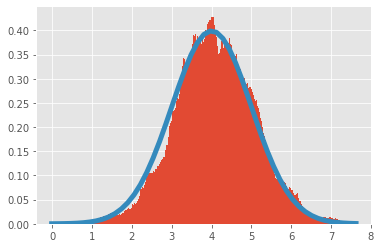

In [4]:
xv = xvals[n_therm:, :]

plt.hist(xv.ravel(), bins='auto', density=True)

xx = np.linspace(xv.min(), xv.max(), 49)
plt.plot(xx, np.exp(-(xx-4).ravel()**2 / 2) / np.sqrt(2*np.pi),  lw=5);

In [6]:
xvals.shape

(1000, 10000)

Now we can compute various integrals:

$$
\int_{\infty}^\infty x^3 e^{-(x - 4)^2 / 2} \, dx
$$

(compare to paper-and-pencil or online)

In [5]:
(xvals**3).mean() * sqrt(2*pi)

200.94265079726867

### Several things to keep in mind

- Autocorrelations

- Burn-in time

- Sample size : convergence rate is $\sim 1/\sqrt{N}$

- Choice of updates

- Not vectorizable (but *embarassingly parallel*)

In [6]:
def plot_norm(ax, xv, loc):
    xmin, xmax = xv.min(), xv.max()
    xx = np.linspace(xmin, xmax, 49)
    ax.plot(xx, np.exp(-(xx.ravel()-loc)**2 / 2) / np.sqrt(2*np.pi), lw=5)

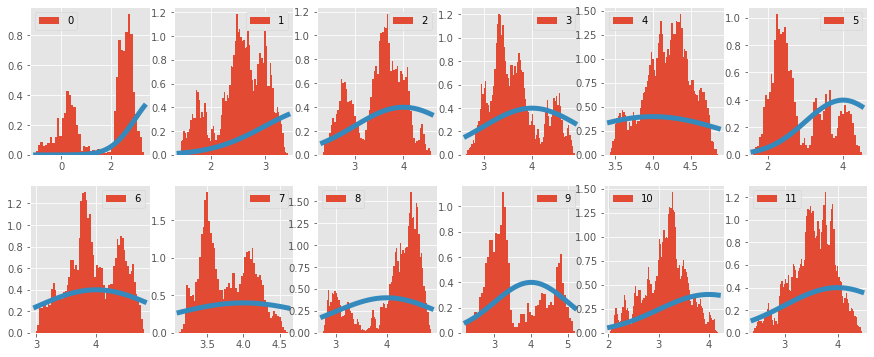

In [7]:
fig, axx = plt.subplots(2, 6, figsize=(15, 6))
for j, ax in enumerate(axx.ravel()):
    xv = xvals[j*10:(j+1)*10, :]
    ax.hist(xv.ravel(), bins='auto', density=True, label='%s' %j)
    plot_norm(ax, xv, 4)
    ax.legend()